<a href="https://colab.research.google.com/github/Yashaswini-UB/Classification-of-3d-object-based-on-shapes/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
def read_off(file_path):
    """ Reads an OFF file and extracts the vertex data as a NumPy array. """
    with open(file_path, 'r') as file:
        off_header = file.readline().strip()
        if 'OFF' == off_header:
            n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        else:
            n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
        faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
        return verts, faces

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/ModelNet40 (2).zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm folder structure
os.listdir(extract_path)

['ModelNet40']

In [ ]:
import os
import torch
from tqdm import tqdm

# ---------------- OFF Reader ----------------
def read_off(file):
    with open(file, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    if lines[0] == "OFF":
        parts = lines[1].split()
        num_verts, num_faces = int(parts[0]), int(parts[1])
        start_idx = 2
    elif lines[0].startswith("OFF"):
        parts = lines[0].replace("OFF", "").split()
        num_verts, num_faces = int(parts[0]), int(parts[1])
        start_idx = 1
    else:
        parts = lines[0].split()
        num_verts, num_faces = int(parts[0]), int(parts[1])
        start_idx = 1

    verts = []
    for i in range(start_idx, start_idx + num_verts):
        vals = list(map(float, lines[i].split()))
        verts.append(vals[:3])

    faces = []
    for i in range(start_idx + num_verts, start_idx + num_verts + num_faces):
        vals = list(map(int, lines[i].split()))
        faces.append(vals[1:])

    return torch.tensor(verts, dtype=torch.float), faces

In [ ]:
# ----------- Point Sampler -----------
class PointSampler(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, mesh):
        verts, faces = mesh
        if verts.shape[0] >= self.output_size:
            indices = torch.randperm(verts.shape[0])[:self.output_size]
            sampled_points = verts[indices]
        else:
            repeat = self.output_size // verts.shape[0] + 1
            sampled_points = verts.repeat((repeat, 1))[:self.output_size]
        return sampled_points

In [ ]:
# ----------- Normalization -----------
class Normalize(object):
    def __call__(self, pointcloud):
        centroid = torch.mean(pointcloud, dim=0)
        pointcloud = pointcloud - centroid
        max_dist = torch.max(torch.sqrt(torch.sum(pointcloud ** 2, dim=1)))
        pointcloud = pointcloud / max_dist
        return pointcloud

In [ ]:
import os
import random
import torch
from tqdm import tqdm

# ----------- Main Preprocessing Function -----------
data_path = '/content/dataset/ModelNet40'  # ✅ correct path with capitals
folders = [dr for dr in sorted(os.listdir(data_path)) if os.path.isdir(f'{data_path}/{dr}')]

os.makedirs("/content/processed/train", exist_ok=True)
os.makedirs("/content/processed/test", exist_ok=True)

def save_point_clouds(train_ratio=0.8, n_points=1024):
    ii = 0
    for dr in folders:  # each category (airplane, chair, ...)
        dataset_dir = os.path.join(data_path, dr)
        dataset_files = [f for f in os.listdir(dataset_dir) if f.lower().endswith(".off")]
        random.shuffle(dataset_files)  # shuffle for randomness

        if len(dataset_files) == 0:
            print(f"⚠️ No .off files found in {dataset_dir}")
            continue

        # Split into train (80%) and test (20%)
        split_idx = int(len(dataset_files) * train_ratio)
        train_files = dataset_files[:split_idx]
        test_files = dataset_files[split_idx:]

        for split, files in [("train", train_files), ("test", test_files)]:
            for file in tqdm(files, desc=f"{dr}-{split}"):
                file_path = os.path.join(dataset_dir, file)
                file_name = file.replace(".off", "")
                save_dir = f"/content/processed/{split}/{dr}"
                os.makedirs(save_dir, exist_ok=True)

                out_path = f"{save_dir}/{file_name}.pt"
                if os.path.exists(out_path):  # ✅ skip if already processed
                    continue

                # ---- Convert OFF -> PointCloud ----
                verts, faces = read_off(file_path)
                pointcloud = PointSampler(n_points)((verts, faces))
                pointcloud = Normalize()(pointcloud)

                torch.save(pointcloud, out_path)
                ii += 1

        print(f"✔️ {dr}: {len(train_files)} train, {len(test_files)} test")

    print(f'\n{ii} new point clouds have been saved into train/test splits!')

# ----------- Run -----------
save_point_clouds(train_ratio=0.8, n_points=1024)


airplane-test: 100%|██████████| 146/146 [01:00<00:00,  2.40it/s]


✔️ airplane: 580 train, 146 test


bathtub-test: 100%|██████████| 32/32 [00:01<00:00, 30.70it/s]


✔️ bathtub: 124 train, 32 test


bed-test: 100%|██████████| 123/123 [00:07<00:00, 17.15it/s]


✔️ bed: 492 train, 123 test


bench-test: 100%|██████████| 39/39 [00:01<00:00, 26.61it/s]


✔️ bench: 154 train, 39 test


bookshelf-test: 100%|██████████| 135/135 [00:11<00:00, 12.03it/s]


✔️ bookshelf: 537 train, 135 test


bottle-test: 100%|██████████| 87/87 [00:03<00:00, 23.59it/s]


✔️ bottle: 348 train, 87 test


bowl-test: 100%|██████████| 17/17 [00:00<00:00, 45.08it/s]


✔️ bowl: 67 train, 17 test


car-test: 100%|██████████| 60/60 [00:25<00:00,  2.39it/s]


✔️ car: 237 train, 60 test


chair-test: 100%|██████████| 198/198 [00:13<00:00, 14.67it/s]


✔️ chair: 791 train, 198 test


cone-test: 100%|██████████| 38/38 [00:00<00:00, 135.50it/s]


✔️ cone: 149 train, 38 test


cup-test: 100%|██████████| 20/20 [00:00<00:00, 54.53it/s]


✔️ cup: 79 train, 20 test


curtain-test: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


✔️ curtain: 126 train, 32 test


desk-test: 100%|██████████| 58/58 [00:02<00:00, 26.71it/s]


✔️ desk: 228 train, 58 test


door-test: 100%|██████████| 26/26 [00:00<00:00, 77.79it/s] 


✔️ door: 103 train, 26 test


dresser-test: 100%|██████████| 58/58 [00:02<00:00, 21.55it/s]


✔️ dresser: 228 train, 58 test


flower_pot-test: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


✔️ flower_pot: 135 train, 34 test


glass_box-test: 100%|██████████| 55/55 [00:00<00:00, 92.84it/s] 


✔️ glass_box: 216 train, 55 test


guitar-test: 100%|██████████| 51/51 [00:12<00:00,  3.95it/s]


✔️ guitar: 204 train, 51 test


keyboard-test: 100%|██████████| 33/33 [00:06<00:00,  5.38it/s]


✔️ keyboard: 132 train, 33 test


lamp-test: 100%|██████████| 29/29 [00:01<00:00, 27.46it/s]


✔️ lamp: 115 train, 29 test


laptop-test: 100%|██████████| 34/34 [00:01<00:00, 28.42it/s]


✔️ laptop: 135 train, 34 test


mantel-test: 100%|██████████| 77/77 [00:08<00:00,  8.74it/s]


✔️ mantel: 307 train, 77 test


monitor-test: 100%|██████████| 113/113 [00:04<00:00, 27.04it/s]


✔️ monitor: 452 train, 113 test


night_stand-test: 100%|██████████| 58/58 [00:01<00:00, 48.04it/s]


✔️ night_stand: 228 train, 58 test


person-test: 100%|██████████| 22/22 [00:01<00:00, 12.36it/s]


✔️ person: 86 train, 22 test


piano-test: 100%|██████████| 67/67 [00:05<00:00, 13.10it/s]


✔️ piano: 264 train, 67 test


plant-test: 100%|██████████| 68/68 [00:15<00:00,  4.50it/s]


✔️ plant: 272 train, 68 test


radio-test: 100%|██████████| 25/25 [00:02<00:00, 11.96it/s]


✔️ radio: 99 train, 25 test


range_hood-test: 100%|██████████| 43/43 [00:01<00:00, 31.36it/s]


✔️ range_hood: 172 train, 43 test


sink-test: 100%|██████████| 30/30 [00:01<00:00, 19.50it/s]


✔️ sink: 118 train, 30 test


sofa-test: 100%|██████████| 156/156 [00:10<00:00, 15.35it/s]


✔️ sofa: 624 train, 156 test


stairs-test: 100%|██████████| 29/29 [00:07<00:00,  3.68it/s]


✔️ stairs: 115 train, 29 test


stool-test: 100%|██████████| 22/22 [00:00<00:00, 34.62it/s]


✔️ stool: 88 train, 22 test


table-test: 100%|██████████| 99/99 [00:02<00:00, 38.00it/s]


✔️ table: 393 train, 99 test


tent-test: 100%|██████████| 37/37 [00:03<00:00, 11.23it/s]


✔️ tent: 146 train, 37 test


toilet-test: 100%|██████████| 89/89 [00:06<00:00, 14.44it/s]


✔️ toilet: 355 train, 89 test


tv_stand-test: 100%|██████████| 74/74 [00:02<00:00, 34.00it/s]


✔️ tv_stand: 293 train, 74 test


vase-test: 100%|██████████| 115/115 [00:04<00:00, 26.71it/s]


✔️ vase: 460 train, 115 test


wardrobe-test: 100%|██████████| 22/22 [00:00<00:00, 41.56it/s]


✔️ wardrobe: 85 train, 22 test


xbox-test: 100%|██████████| 25/25 [00:01<00:00, 13.77it/s]

✔️ xbox: 98 train, 25 test

12311 new point clouds have been saved into train/test splits!


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

# ---------------- Transforms ----------------
def default_transforms():
    """Simple transform returning just the pointcloud (already normalized)."""
    return lambda mesh: mesh[0]  # mesh is (verts, faces), we ignore faces

# ---------------- Dataset Class ----------------
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, get_testset=False, transform=default_transforms()):
        self.split = 'test' if get_testset else 'train'
        self.root_dir = root_dir
        self.transforms = transform

        split_dir = os.path.join(root_dir, self.split)
        if not os.path.isdir(split_dir):
            raise FileNotFoundError(f"Directory not found: {split_dir}")

        # list all category folders inside this split
        folders = [d for d in sorted(os.listdir(split_dir)) if os.path.isdir(os.path.join(split_dir, d))]
        self.classes = {folder: i for i, folder in enumerate(folders)}

        self.files = []
        self.labels = []

        for class_name, label in self.classes.items():
            class_dir = os.path.join(split_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.pt'):
                    self.files.append(os.path.join(class_dir, file_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pcd_path = self.files[idx]
        label = self.labels[idx]
        pointcloud = torch.load(pcd_path)
        if self.transforms:
            pointcloud = self.transforms((pointcloud, None)) if callable(self.transforms) else pointcloud
        return {'pointcloud': pointcloud, 'category': label}

# ---------------- Load Dataset ----------------
data_path = "/content/processed"  # processed folder containing train/test splits

train_dataset = PointCloudDataset(data_path, get_testset=False)
val_dataset = PointCloudDataset(data_path, get_testset=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

Train samples: 9835, Val samples: 2476


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
import os, random, itertools, warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00


In [ ]:
try:
    from torch_geometric.data import Data
    from torch_geometric.loader import DataLoader as PyGDataLoader
    from torch_geometric.nn import EdgeConv, global_max_pool, knn_graph
    PYG_AVAILABLE = True
except:
    PYG_AVAILABLE = False
    print("PyG not available; GNN will be skipped.")

In [ ]:
# ---------------------------
# Dataset utilities (from your code)
# ---------------------------

def default_transforms():
    return lambda mesh: mesh[0]

class PointCloudDataset(Dataset):
    """Generic pointcloud dataset returning dict {'pointcloud': Tensor(B,N,3) , 'category': int}"""
    def __init__(self, root_dir, split='train', transform=default_transforms()):
        self.split = split
        self.root_dir = root_dir
        self.transforms = transform

        split_dir = os.path.join(root_dir, self.split)
        if not os.path.isdir(split_dir):
            raise FileNotFoundError(f"Directory not found: {split_dir}")

        folders = [d for d in sorted(os.listdir(split_dir)) if os.path.isdir(os.path.join(split_dir, d))]
        self.classes = {folder: i for i, folder in enumerate(folders)}

        self.files, self.labels = [], []
        for class_name, label in self.classes.items():
            class_dir = os.path.join(split_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.pt'):
                    self.files.append(os.path.join(class_dir, file_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pcd = torch.load(self.files[idx])  # expected shape (N,3) or (1024,3)
        if self.transforms:
            pcd = self.transforms((pcd, None)) if callable(self.transforms) else pcd
        return {'pointcloud': pcd.float(), 'category': self.labels[idx]}

In [ ]:
# Graph dataset for PyG (GNN)
if PYG_AVAILABLE:
    class PointCloudGraphDataset(Dataset):
        def __init__(self, root_dir, split='train', transform=default_transforms(), k=20):
            self.split = split
            self.root_dir = root_dir
            self.transforms = transform
            self.k = k

            split_dir = os.path.join(root_dir, self.split)
            if not os.path.isdir(split_dir):
                raise FileNotFoundError(f"Directory not found: {split_dir}")

            folders = [d for d in sorted(os.listdir(split_dir)) if os.path.isdir(os.path.join(split_dir, d))]
            self.classes = {folder: i for i, folder in enumerate(folders)}
            self.files, self.labels = [], []
            for class_name, label in self.classes.items():
                class_dir = os.path.join(split_dir, class_name)
                for file_name in os.listdir(class_dir):
                    if file_name.endswith('.pt'):
                        self.files.append(os.path.join(class_dir, file_name))
                        self.labels.append(label)

        def __len__(self):
            return len(self.files)

        def __getitem__(self, idx):
            points = torch.load(self.files[idx])
            if self.transforms:
                points = self.transforms((points, None)) if callable(self.transforms) else points
            edge_index = knn_graph(points, k=self.k, loop=False)
            data = Data(x=points.float(), edge_index=edge_index, y=torch.tensor([self.labels[idx]], dtype=torch.long))
            return data

In [ ]:
# ---------------------------
# Model definitions (copied/adapted from your code)
# ---------------------------

# 1) PointNet2-style small classifier
class PointNet2Classification(nn.Module):
    def __init__(self, num_classes=40):
        super(PointNet2Classification, self).__init__()
        self.mlp1 = nn.Sequential(nn.Conv1d(3,64,1), nn.BatchNorm1d(64), nn.ReLU())
        self.mlp2 = nn.Sequential(nn.Conv1d(64,128,1), nn.BatchNorm1d(128), nn.ReLU())
        self.mlp3 = nn.Sequential(nn.Conv1d(128,256,1), nn.BatchNorm1d(256), nn.ReLU())
        self.mlp4 = nn.Sequential(nn.Conv1d(256,512,1), nn.BatchNorm1d(512), nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.4),
                                nn.Linear(256,128), nn.ReLU(), nn.Dropout(0.4),
                                nn.Linear(128,num_classes))
    def forward(self,x):
        # accept x as (B,N,3) or (B,3,N)
        if x.ndim==3 and x.shape[-1]==3:
            x = x.permute(0,2,1)
        x = self.mlp1(x); x = self.mlp2(x); x = self.mlp3(x); x = self.mlp4(x)
        x = torch.max(x,2)[0]
        return self.fc(x)

In [ ]:
# 2) DGCNN (from your code)
def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2,1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2,1)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

def get_graph_feature(x, k=20):
    batch_size, num_dims, num_points = x.size()
    idx = knn(x, k=k)
    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1,1,1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)
    x = x.transpose(2,1).contiguous()
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1,1,k,1)
    feature = torch.cat((feature - x, x), dim=3).permute(0,3,1,2)
    return feature

class DGCNN(nn.Module):
    def __init__(self, num_classes=40, k=20):
        super(DGCNN,self).__init__()
        self.k = k
        self.bn1 = nn.BatchNorm2d(64); self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128); self.bn4 = nn.BatchNorm2d(256); self.bn5 = nn.BatchNorm1d(1024)
        self.conv1 = nn.Sequential(nn.Conv2d(6,64,1,bias=False), self.bn1, nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(128,64,1,bias=False), self.bn2, nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(128,128,1,bias=False), self.bn3, nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(256,256,1,bias=False), self.bn4, nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512,1024,1,bias=False), self.bn5, nn.LeakyReLU(0.2))
        self.linear1 = nn.Linear(2048,512,bias=False); self.bn6 = nn.BatchNorm1d(512); self.dp1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(512,256); self.bn7 = nn.BatchNorm1d(256); self.dp2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(256, num_classes)
    def forward(self, x):
        # expects x: (B,N,3)
        x = x.permute(0,2,1)  # (B,3,N)
        batch_size = x.size(0)
        x1 = self.conv1(get_graph_feature(x, k=self.k)).max(dim=-1)[0]
        x2 = self.conv2(get_graph_feature(x1, k=self.k)).max(dim=-1)[0]
        x3 = self.conv3(get_graph_feature(x2, k=self.k)).max(dim=-1)[0]
        x4 = self.conv4(get_graph_feature(x3, k=self.k)).max(dim=-1)[0]
        x_cat = torch.cat((x1,x2,x3,x4), dim=1)
        x5 = self.conv5(x_cat)
        x_max = F.adaptive_max_pool1d(x5,1).view(batch_size, -1)
        x_avg = F.adaptive_avg_pool1d(x5,1).view(batch_size, -1)
        x = torch.cat((x_max, x_avg), 1)
        x = F.leaky_relu(self.bn6(self.linear1(x)),0.2); x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)),0.2); x = self.dp2(x)
        x = self.linear3(x)
        return x

In [ ]:
# 3) GNN (EdgeConv) - requires PyG
if PYG_AVAILABLE:
    class GNN(nn.Module):
        def __init__(self, num_classes, k=20):
            super(GNN, self).__init__()
            self.k = k
            self.conv1 = EdgeConv(nn.Sequential(nn.Linear(6,64), nn.ReLU()))
            self.conv2 = EdgeConv(nn.Sequential(nn.Linear(128,64), nn.ReLU()))
            self.conv3 = EdgeConv(nn.Sequential(nn.Linear(128,128), nn.ReLU()))
            self.conv4 = EdgeConv(nn.Sequential(nn.Linear(256,256), nn.ReLU()))
            self.fc1 = nn.Linear(256*2, 512); self.bn1 = nn.BatchNorm1d(512); self.dp1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(512, 256); self.bn2 = nn.BatchNorm1d(256); self.dp2 = nn.Dropout(0.5)
            self.fc3 = nn.Linear(256, num_classes)
        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x1 = self.conv1(x, edge_index)
            x2 = self.conv2(x1, edge_index)
            x3 = self.conv3(x2, edge_index)
            x4 = self.conv4(x3, edge_index)
            x_cat = x4
            x_max = global_max_pool(x_cat, batch)
            x_mean = global_mean_pool(x_cat, batch)
            x = torch.cat([x_max, x_mean], dim=1)
            x = F.relu(self.bn1(self.fc1(x))); x = self.dp1(x)
            x = F.relu(self.bn2(self.fc2(x))); x = self.dp2(x)
            x = self.fc3(x)
            return x

In [ ]:
# 4) Transformer
class PointTransformerModel(nn.Module):
    def __init__(self, num_classes, num_points=1024, embed_dim=128, depth=4, heads=4):
        super(PointTransformerModel, self).__init__()
        self.embedding = nn.Linear(3, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, dim_feedforward=256, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.fc1 = nn.Linear(embed_dim, 256); self.bn1 = nn.BatchNorm1d(256); self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128); self.bn2 = nn.BatchNorm1d(128); self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        # x: (B,N,3)
        x = self.embedding(x)  # (B,N,embed)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = F.relu(self.bn1(self.fc1(x))); x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x))); x = self.dp2(x)
        x = self.fc3(x)
        return x

In [ ]:
# 5) KPConv (a simple Conv1D-based proxy)
class KPConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(KPConvBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, 1, bias=False),
                                  nn.BatchNorm1d(out_channels), nn.ReLU())
    def forward(self,x):
        return self.conv(x)

class KPConvModel(nn.Module):
    def __init__(self, num_classes=40):
        super(KPConvModel, self).__init__()
        self.block1 = KPConvBlock(3,64); self.block2 = KPConvBlock(64,128)
        self.block3 = KPConvBlock(128,256); self.block4 = KPConvBlock(256,512)
        self.fc1 = nn.Linear(512*2, 512); self.bn1 = nn.BatchNorm1d(512); self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256); self.bn2 = nn.BatchNorm1d(256); self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)
    def forward(self, x):
        # x: (B,N,3) -> conv expects (B,3,N)
        x = x.permute(0,2,1)
        x1 = self.block1(x); x2 = self.block2(x1); x3 = self.block3(x2); x4 = self.block4(x3)
        x_max = F.adaptive_max_pool1d(x4,1).squeeze(-1)
        x_avg = F.adaptive_avg_pool1d(x4,1).squeeze(-1)
        x = torch.cat([x_max, x_avg], dim=1)
        x = F.relu(self.bn1(self.fc1(x))); x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x))); x = self.dp2(x)
        x = self.fc3(x)
        return x

In [ ]:
# ---------------------------
# Training / evaluation helpers
# ---------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths & hyperparameters - edit as needed
RAW_ROOT = "/content/dataset/ModelNet40"   # original .off dataset
DATA_ROOT = "/content/processed"     # your existing processed folder
BATCH_SIZE = 32
EPOCHS = 20         # change to larger value for real training
LR = 0.001

Device: cuda


In [ ]:
import os
print(os.listdir(DATA_ROOT))
print(os.listdir(os.path.join(DATA_ROOT, 'train')))


['train', 'test']
['bed', 'bottle', 'vase', 'tent', 'airplane', 'desk', 'person', 'night_stand', 'tv_stand', 'wardrobe', 'mantel', 'stairs', 'bench', 'dresser', 'xbox', 'cone', 'door', 'range_hood', 'keyboard', 'cup', 'plant', 'sink', 'laptop', 'flower_pot', 'monitor', 'bowl', 'radio', 'lamp', 'toilet', 'bookshelf', 'piano', 'guitar', 'stool', 'curtain', 'bathtub', 'sofa', 'table', 'glass_box', 'car', 'chair']


In [ ]:
# Create datasets / loaders
train_dataset = PointCloudDataset(DATA_ROOT, split='train', transform=default_transforms())
val_dataset = PointCloudDataset(DATA_ROOT, split='test', transform=default_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

if PYG_AVAILABLE:
    train_graph_dataset = PointCloudGraphDataset(DATA_ROOT, split='train', transform=default_transforms(), k=20)
    val_graph_dataset = PointCloudGraphDataset(DATA_ROOT, split='test', transform=default_transforms(), k=20)
    train_graph_loader = PyGDataLoader(train_graph_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_graph_loader = PyGDataLoader(val_graph_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
class_names = list(train_dataset.classes.keys())
print(f"Num classes: {num_classes}, classes sample: {class_names[:5]}")

Num classes: 40, classes sample: ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf']


In [ ]:
# Generic train/eval that works for DataLoader models (PointNet2, DGCNN, Transformer, KPConv)
def train_model_classic(model, train_loader, val_loader, epochs, optimizer, criterion, model_name):
    model.to(device)
    train_losses, train_accs, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss=0; correct=0; total=0
        for batch in train_loader:
            inputs = batch['pointcloud'].to(device).float()  # (B,N,3)
            labels = batch['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
        train_loss = total_loss/len(train_loader)
        train_acc = 100.*correct/total if total>0 else 0
        train_losses.append(train_loss); train_accs.append(train_acc)
        # validation
        model.eval()
        val_correct=0; val_total=0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['pointcloud'].to(device).float()
                labels = batch['category'].to(device)
                outputs = model(inputs)
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()
        val_acc = 100.*val_correct/val_total if val_total>0 else 0
        val_accs.append(val_acc)
        print(f"[{model_name}] Epoch {epoch+1}/{epochs} loss={train_loss:.4f} train_acc={train_acc:.2f}% val_acc={val_acc:.2f}%")
    return train_losses, train_accs, val_accs

In [ ]:
# GNN train/eval (PyG)
def train_model_gnn(model, train_graph_loader, val_graph_loader, epochs, optimizer, criterion, model_name):
    if not PYG_AVAILABLE:
        raise RuntimeError("PyG not installed - can't run GNN.")
    model.to(device)
    train_losses, train_accs, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss=0; correct=0; total=0
        for data in train_graph_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += data.y.size(0)
            correct += pred.eq(data.y.view(-1)).sum().item()
        train_losses.append(total_loss/len(train_graph_loader))
        train_accs.append(100.*correct/total if total>0 else 0)
        # validation
        model.eval()
        val_correct=0; val_total=0
        with torch.no_grad():
            for data in val_graph_loader:
                data = data.to(device)
                outputs = model(data)
                _, pred = outputs.max(1)
                val_total += data.y.size(0)
                val_correct += pred.eq(data.y.view(-1)).sum().item()
        val_accs.append(100.*val_correct/val_total if val_total>0 else 0)
        print(f"[{model_name}] Epoch {epoch+1}/{epochs} loss={train_losses[-1]:.4f} train_acc={train_accs[-1]:.2f}% val_acc={val_accs[-1]:.2f}%")
    return train_losses, train_accs, val_accs

In [ ]:
# Evaluation: return preds, labels, accuracy
def evaluate_classic(model, loader):
    model.eval(); all_preds=[]; all_labels=[]
    with torch.no_grad():
        for batch in loader:
            inputs = batch['pointcloud'].to(device).float()
            labels = batch['category'].to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100.*(np.array(all_preds)==np.array(all_labels)).mean() if len(all_labels)>0 else 0
    return all_preds, all_labels, acc

def evaluate_gnn(model, loader):
    if not PYG_AVAILABLE:
        raise RuntimeError("PyG not installed - can't run GNN evaluation.")
    model.eval(); all_preds=[]; all_labels=[]
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            outputs = model(data)
            _, pred = outputs.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())
    acc = 100.*(np.array(all_preds)==np.array(all_labels)).mean() if len(all_labels)>0 else 0
    return all_preds, all_labels, acc

In [ ]:
import os
import time
import warnings
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


trained_models = ['PointNet++', 'DGCNN', 'GNN', 'Transformer', 'KPConv']
results = {}

In [ ]:
# ---------------------------
# Train & Evaluate Models
# ---------------------------

# 1) PointNet2
pn_model = PointNet2Classification(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(pn_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
print("Training PointNet++...")
pn_train_losses, pn_train_accs, pn_val_accs = train_model_classic(pn_model, train_loader, val_loader, EPOCHS, optimizer, criterion, "PointNet2")
pn_preds, pn_labels, pn_test_acc = evaluate_classic(pn_model, val_loader)
training_time = time.time() - start_time
cm_pn = confusion_matrix(pn_labels, pn_preds)
results['PointNet2'] = {
    'model': pn_model, 'train_losses':pn_train_losses, 'train_accs':pn_train_accs,
    'val_accs':pn_val_accs, 'test_acc':pn_test_acc, 'preds':pn_preds, 'labels':pn_labels,
    'cm':cm_pn, 'training_time': training_time, 'optimizer':'Adam'
}

Training PointNet++...
[PointNet2] Epoch 1/20 loss=2.5046 train_acc=33.35% val_acc=51.09%
[PointNet2] Epoch 2/20 loss=1.7556 train_acc=50.44% val_acc=62.48%
[PointNet2] Epoch 3/20 loss=1.5514 train_acc=55.43% val_acc=64.66%
[PointNet2] Epoch 4/20 loss=1.4229 train_acc=58.63% val_acc=65.51%
[PointNet2] Epoch 5/20 loss=1.3508 train_acc=60.33% val_acc=67.77%
[PointNet2] Epoch 6/20 loss=1.3032 train_acc=61.78% val_acc=70.72%
[PointNet2] Epoch 7/20 loss=1.2630 train_acc=62.64% val_acc=71.45%
[PointNet2] Epoch 8/20 loss=1.1927 train_acc=63.97% val_acc=73.99%
[PointNet2] Epoch 9/20 loss=1.1756 train_acc=65.36% val_acc=74.11%
[PointNet2] Epoch 10/20 loss=1.1190 train_acc=66.58% val_acc=72.78%
[PointNet2] Epoch 11/20 loss=1.1265 train_acc=66.47% val_acc=74.35%
[PointNet2] Epoch 12/20 loss=1.0668 train_acc=68.19% val_acc=74.88%
[PointNet2] Epoch 13/20 loss=1.0549 train_acc=68.22% val_acc=75.44%
[PointNet2] Epoch 14/20 loss=1.0457 train_acc=68.95% val_acc=75.12%
[PointNet2] Epoch 15/20 loss=1.016

In [ ]:
# 2) DGCNN
dg_model = DGCNN(num_classes=num_classes, k=20).to(device)
optimizer = torch.optim.Adam(dg_model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
print("Training DGCNN...")
dg_train_losses, dg_train_accs, dg_val_accs = train_model_classic(dg_model, train_loader, val_loader, EPOCHS, optimizer, criterion, "DGCNN")
dg_preds, dg_labels, dg_test_acc = evaluate_classic(dg_model, val_loader)
training_time = time.time() - start_time
cm_dg = confusion_matrix(dg_labels, dg_preds)
results['DGCNN'] = {
    'model': dg_model, 'train_losses':dg_train_losses, 'train_accs':dg_train_accs,
    'val_accs':dg_val_accs, 'test_acc':dg_test_acc, 'preds':dg_preds, 'labels':dg_labels,
    'cm':cm_dg, 'training_time': training_time, 'optimizer':'Adam'
}

Training DGCNN...
[DGCNN] Epoch 1/20 loss=1.8673 train_acc=51.37% val_acc=59.69%
[DGCNN] Epoch 2/20 loss=1.1738 train_acc=66.26% val_acc=74.52%
[DGCNN] Epoch 3/20 loss=0.9995 train_acc=71.13% val_acc=76.86%
[DGCNN] Epoch 4/20 loss=0.8826 train_acc=73.79% val_acc=77.87%
[DGCNN] Epoch 5/20 loss=0.8298 train_acc=75.40% val_acc=76.01%
[DGCNN] Epoch 6/20 loss=0.7605 train_acc=77.31% val_acc=79.00%
[DGCNN] Epoch 7/20 loss=0.7173 train_acc=78.31% val_acc=74.92%
[DGCNN] Epoch 8/20 loss=0.6900 train_acc=78.79% val_acc=78.39%
[DGCNN] Epoch 9/20 loss=0.6507 train_acc=79.94% val_acc=80.25%
[DGCNN] Epoch 10/20 loss=0.6198 train_acc=80.57% val_acc=80.90%
[DGCNN] Epoch 11/20 loss=0.6018 train_acc=81.45% val_acc=81.66%
[DGCNN] Epoch 12/20 loss=0.5788 train_acc=82.04% val_acc=80.78%
[DGCNN] Epoch 13/20 loss=0.5488 train_acc=82.83% val_acc=81.22%
[DGCNN] Epoch 14/20 loss=0.5322 train_acc=83.57% val_acc=80.61%
[DGCNN] Epoch 15/20 loss=0.5176 train_acc=84.11% val_acc=80.86%
[DGCNN] Epoch 16/20 loss=0.4910

In [ ]:
from torch_geometric.nn import EdgeConv, global_max_pool, global_mean_pool

In [ ]:
def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch

    # Example EdgeConv layers
    x1 = F.relu(self.conv1(x, edge_index))
    x2 = F.relu(self.conv2(x1, edge_index))
    x3 = F.relu(self.conv3(x2, edge_index))
    x4 = torch.cat([x1, x2, x3], dim=1)  # concatenating features from multiple layers

    # Global pooling
    x_max = global_max_pool(x4, batch)
    x_mean = global_mean_pool(x4, batch)
    x = torch.cat([x_max, x_mean], dim=1)

    # Fully connected layers
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.dp1(x)
    x = self.fc2(x)
    return x


In [ ]:
# 3) GNN (EdgeConv)
if PYG_AVAILABLE:
    gnn_model = GNN(num_classes=num_classes, k=20).to(device)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    print("Training GNN (EdgeConv)...")
    gnn_train_losses, gnn_train_accs, gnn_val_accs = train_model_gnn(gnn_model, train_graph_loader, val_graph_loader, EPOCHS, optimizer, criterion, "GNN")
    gnn_preds, gnn_labels, gnn_test_acc = evaluate_gnn(gnn_model, val_graph_loader)
    training_time = time.time() - start_time
    cm_gnn = confusion_matrix(gnn_labels, gnn_preds)
    results['GNN'] = {
        'model': gnn_model, 'train_losses':gnn_train_losses, 'train_accs':gnn_train_accs,
        'val_accs':gnn_val_accs, 'test_acc':gnn_test_acc, 'preds':gnn_preds, 'labels':gnn_labels,
        'cm':cm_gnn, 'training_time': training_time, 'optimizer':'Adam'
    }
else:
    print("Skipping GNN training/eval because PyG not installed.")


Training GNN (EdgeConv)...
[GNN] Epoch 1/20 loss=2.0401 train_acc=48.06% val_acc=48.83%
[GNN] Epoch 2/20 loss=1.3003 train_acc=63.40% val_acc=67.45%
[GNN] Epoch 3/20 loss=1.0912 train_acc=68.83% val_acc=74.39%
[GNN] Epoch 4/20 loss=1.0139 train_acc=70.31% val_acc=71.57%
[GNN] Epoch 5/20 loss=0.9233 train_acc=72.87% val_acc=76.17%
[GNN] Epoch 6/20 loss=0.8741 train_acc=74.07% val_acc=74.39%
[GNN] Epoch 7/20 loss=0.8261 train_acc=75.21% val_acc=78.39%
[GNN] Epoch 8/20 loss=0.7752 train_acc=76.53% val_acc=76.66%
[GNN] Epoch 9/20 loss=0.7450 train_acc=77.57% val_acc=78.76%
[GNN] Epoch 10/20 loss=0.7136 train_acc=78.40% val_acc=78.55%
[GNN] Epoch 11/20 loss=0.7094 train_acc=78.56% val_acc=77.75%
[GNN] Epoch 12/20 loss=0.6652 train_acc=79.80% val_acc=76.49%
[GNN] Epoch 13/20 loss=0.6462 train_acc=80.33% val_acc=79.32%
[GNN] Epoch 14/20 loss=0.6232 train_acc=80.72% val_acc=79.00%
[GNN] Epoch 15/20 loss=0.6167 train_acc=80.80% val_acc=77.30%
[GNN] Epoch 16/20 loss=0.6057 train_acc=81.00% val_a

In [ ]:
# 4) Transformer
tr_model = PointTransformerModel(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(tr_model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
print("Training Transformer...")
tr_train_losses, tr_train_accs, tr_val_accs = train_model_classic(tr_model, train_loader, val_loader, EPOCHS, optimizer, criterion, "Transformer")
tr_preds, tr_labels, tr_test_acc = evaluate_classic(tr_model, val_loader)
training_time = time.time() - start_time
cm_tr = confusion_matrix(tr_labels, tr_preds)
results['Transformer'] = {
    'model': tr_model, 'train_losses':tr_train_losses, 'train_accs':tr_train_accs,
    'val_accs':tr_val_accs, 'test_acc':tr_test_acc, 'preds':tr_preds, 'labels':tr_labels,
    'cm':cm_tr, 'training_time': training_time, 'optimizer':'Adam'
}

Training Transformer...
[Transformer] Epoch 1/20 loss=2.5206 train_acc=34.64% val_acc=49.23%
[Transformer] Epoch 2/20 loss=1.7846 train_acc=51.20% val_acc=53.03%
[Transformer] Epoch 3/20 loss=1.5370 train_acc=56.83% val_acc=61.43%
[Transformer] Epoch 4/20 loss=1.4014 train_acc=60.11% val_acc=64.10%
[Transformer] Epoch 5/20 loss=1.3238 train_acc=61.77% val_acc=64.90%
[Transformer] Epoch 6/20 loss=1.2690 train_acc=63.24% val_acc=68.58%
[Transformer] Epoch 7/20 loss=1.2268 train_acc=64.38% val_acc=71.81%
[Transformer] Epoch 8/20 loss=1.1676 train_acc=65.73% val_acc=67.53%
[Transformer] Epoch 9/20 loss=1.1434 train_acc=66.74% val_acc=68.58%
[Transformer] Epoch 10/20 loss=1.1026 train_acc=68.44% val_acc=72.90%
[Transformer] Epoch 11/20 loss=1.0994 train_acc=68.45% val_acc=73.26%
[Transformer] Epoch 12/20 loss=1.0370 train_acc=69.80% val_acc=72.94%
[Transformer] Epoch 13/20 loss=1.0133 train_acc=70.85% val_acc=70.92%
[Transformer] Epoch 14/20 loss=0.9943 train_acc=71.31% val_acc=71.65%
[Tran

In [ ]:
# 5) KPConv
kp_model = KPConvModel(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(kp_model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
print("Training KPConv...")
kp_train_losses, kp_train_accs, kp_val_accs = train_model_classic(kp_model, train_loader, val_loader, EPOCHS, optimizer, criterion, "KPConv")
kp_preds, kp_labels, kp_test_acc = evaluate_classic(kp_model, val_loader)
training_time = time.time() - start_time
cm_kp = confusion_matrix(kp_labels, kp_preds)
results['KPConv'] = {
    'model': kp_model, 'train_losses':kp_train_losses, 'train_accs':kp_train_accs,
    'val_accs':kp_val_accs, 'test_acc':kp_test_acc, 'preds':kp_preds, 'labels':kp_labels,
    'cm':cm_kp, 'training_time': training_time, 'optimizer':'Adam'
}

Training KPConv...
[KPConv] Epoch 1/20 loss=1.7761 train_acc=53.90% val_acc=68.62%
[KPConv] Epoch 2/20 loss=1.1890 train_acc=66.31% val_acc=72.70%
[KPConv] Epoch 3/20 loss=1.0358 train_acc=70.48% val_acc=76.90%
[KPConv] Epoch 4/20 loss=0.9375 train_acc=72.72% val_acc=77.38%
[KPConv] Epoch 5/20 loss=0.8849 train_acc=73.96% val_acc=79.00%
[KPConv] Epoch 6/20 loss=0.8269 train_acc=75.26% val_acc=80.09%
[KPConv] Epoch 7/20 loss=0.8050 train_acc=76.18% val_acc=78.72%
[KPConv] Epoch 8/20 loss=0.7557 train_acc=77.13% val_acc=80.98%
[KPConv] Epoch 9/20 loss=0.7293 train_acc=77.94% val_acc=80.74%
[KPConv] Epoch 10/20 loss=0.7189 train_acc=78.24% val_acc=81.02%
[KPConv] Epoch 11/20 loss=0.6836 train_acc=79.14% val_acc=80.57%
[KPConv] Epoch 12/20 loss=0.6685 train_acc=79.53% val_acc=82.67%
[KPConv] Epoch 13/20 loss=0.6625 train_acc=80.10% val_acc=82.63%
[KPConv] Epoch 14/20 loss=0.6225 train_acc=80.90% val_acc=83.20%
[KPConv] Epoch 15/20 loss=0.6290 train_acc=80.44% val_acc=81.18%
[KPConv] Epoch 

In [ ]:
# ---------------------------
# Summary Table
# ---------------------------
summary = []
for name in results.keys():
    last_train_acc = results[name]['train_accs'][-1] if len(results[name]['train_accs'])>0 else None
    last_val_acc = results[name]['val_accs'][-1] if len(results[name]['val_accs'])>0 else None
    last_train_loss = results[name]['train_losses'][-1] if len(results[name]['train_losses'])>0 else None
    summary.append({
        'Model': name,
        'Optimizer': results[name].get('optimizer', 'Unknown'),
        'Train Acc (%)': round(last_train_acc,2) if last_train_acc is not None else None,
        'Validation Acc (%)': round(last_val_acc,2) if last_val_acc is not None else None,
        'Train Loss': round(last_train_loss,4) if last_train_loss is not None else None,
        'Test Acc (%)': round(results[name].get('test_acc', 0),2),
        'Training Time (s)': round(results[name].get('training_time', 0),2)
    })

summary_df = pd.DataFrame(summary)
print("\n✅ Summary Table:\n")
print(summary_df)
os.makedirs("results", exist_ok=True)
summary_csv_path = "results/multimodel_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)
print(f"✅ Saved summary table to '{summary_csv_path}'")

# ---------------------------
# Evaluation Metrics Table
# ---------------------------
eval_metrics_list = []
for name in results.keys():
    precision = precision_score(results[name]['labels'], results[name]['preds'], average='macro')
    recall = recall_score(results[name]['labels'], results[name]['preds'], average='macro')
    f1 = f1_score(results[name]['labels'], results[name]['preds'], average='macro')
    eval_metrics_list.append({
        'Model': name,
        'Precision': round(precision,4),
        'Recall': round(recall,4),
        'F1-Score': round(f1,4)
    })

eval_metrics_df = pd.DataFrame(eval_metrics_list)
print("\n✅ Evaluation Metrics Table:\n")
print(eval_metrics_df)
eval_metrics_file = "results/eval_metrics_multimodel.csv"
eval_metrics_df.to_csv(eval_metrics_file, index=False)
print(f"✅ Saved evaluation metrics to '{eval_metrics_file}'")

# ---------------------------
# Save Model Weights
# ---------------------------
os.makedirs("saved_models", exist_ok=True)
for name in results.keys():
    torch.save(results[name]['model'].state_dict(), f"saved_models/{name}_weights.pth")
    print(f"Saved weights for {name} -> saved_models/{name}_weights.pth")

print("\n✅ All done. Check 'results/' for CSVs and 'saved_models/' for weights.")


✅ Summary Table:

         Model Optimizer  Train Acc (%)  Validation Acc (%)  Train Loss  \
0    PointNet2      Adam          71.34               77.67      0.9541   
1        DGCNN      Adam          86.23               81.38      0.4341   
2          GNN      Adam          83.76               82.63      0.5158   
3  Transformer      Adam          74.36               76.05      0.8754   
4       KPConv      Adam          82.66               83.20      0.5578   

   Test Acc (%)  Training Time (s)  
0         77.67             154.62  
1         81.38            2680.10  
2         82.63            2740.45  
3         76.05            1615.33  
4         83.20             162.22  
✅ Saved summary table to 'results/multimodel_summary.csv'

✅ Evaluation Metrics Table:

         Model  Precision  Recall  F1-Score
0    PointNet2     0.6852  0.6620    0.6563
1        DGCNN     0.7726  0.7548    0.7471
2          GNN     0.7859  0.7441    0.7519
3  Transformer     0.6793  0.6454    0.6413


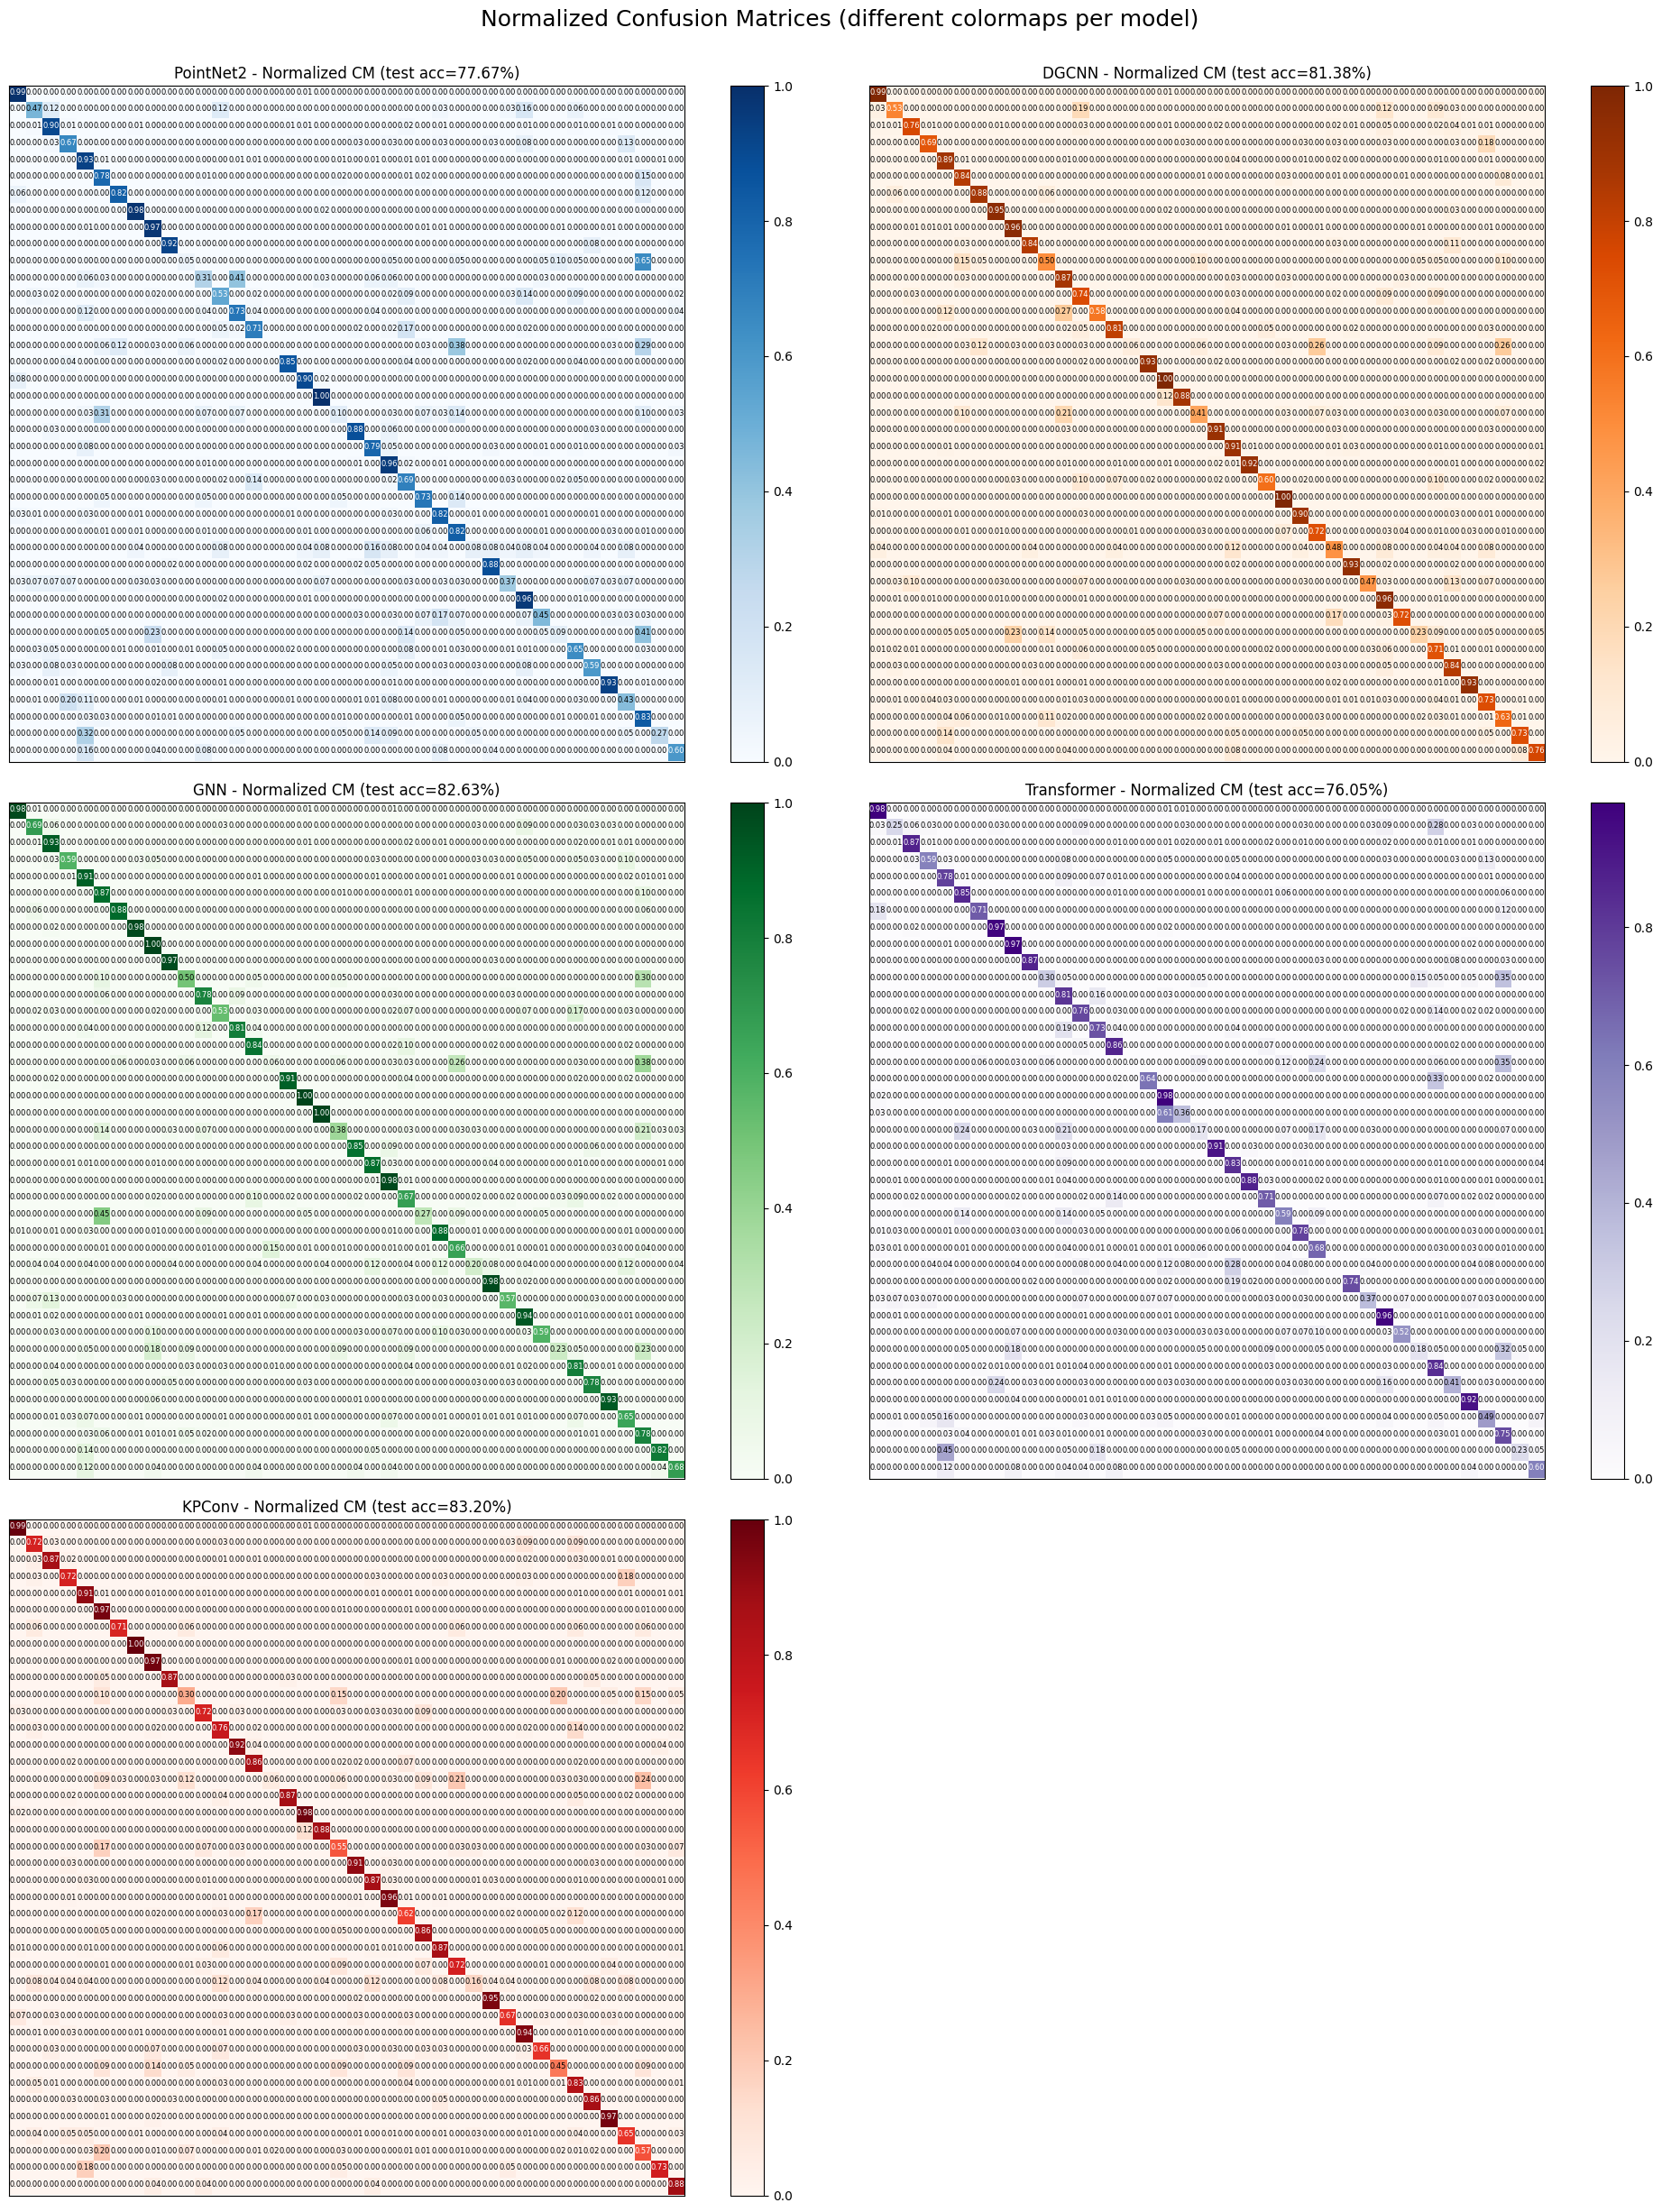

Saved: confusion_matrices_all_models.png


In [ ]:
# ---------------------------
# Plot confusion matrices (each model with different colormap)
# ---------------------------

cmaps = {
    'PointNet2':'Blues',
    'DGCNN':'Oranges',
    'GNN':'Greens',
    'Transformer':'Purples',
    'KPConv':'Reds'
}

# Only show models actually trained
trained_models = list(results.keys())
n = len(trained_models)
cols = 2
rows = (n+cols-1)//cols
plt.figure(figsize=(10*cols, 8*rows))
for idx, name in enumerate(trained_models):
    cm = results[name]['cm']
    # normalize display
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    plt.subplot(rows, cols, idx+1)
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmaps.get(name, 'viridis'))
    plt.title(f"{name} - Normalized CM (test acc={results[name]['test_acc']:.2f}%)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    # for readability limit ticks if too many classes
    if len(class_names) <= 30:
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
    else:
        plt.xticks([])
        plt.yticks([])
    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        # show only diagonal / small subset if huge class count? we'll show all but small font
        plt.text(j, i, format(cm_norm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black", fontsize=6)
    plt.tight_layout()
plt.suptitle("Normalized Confusion Matrices (different colormaps per model)", y=1.02, fontsize=18)
plt.savefig("confusion_matrices_all_models.png", bbox_inches='tight')
plt.show()
print("Saved: confusion_matrices_all_models.png")

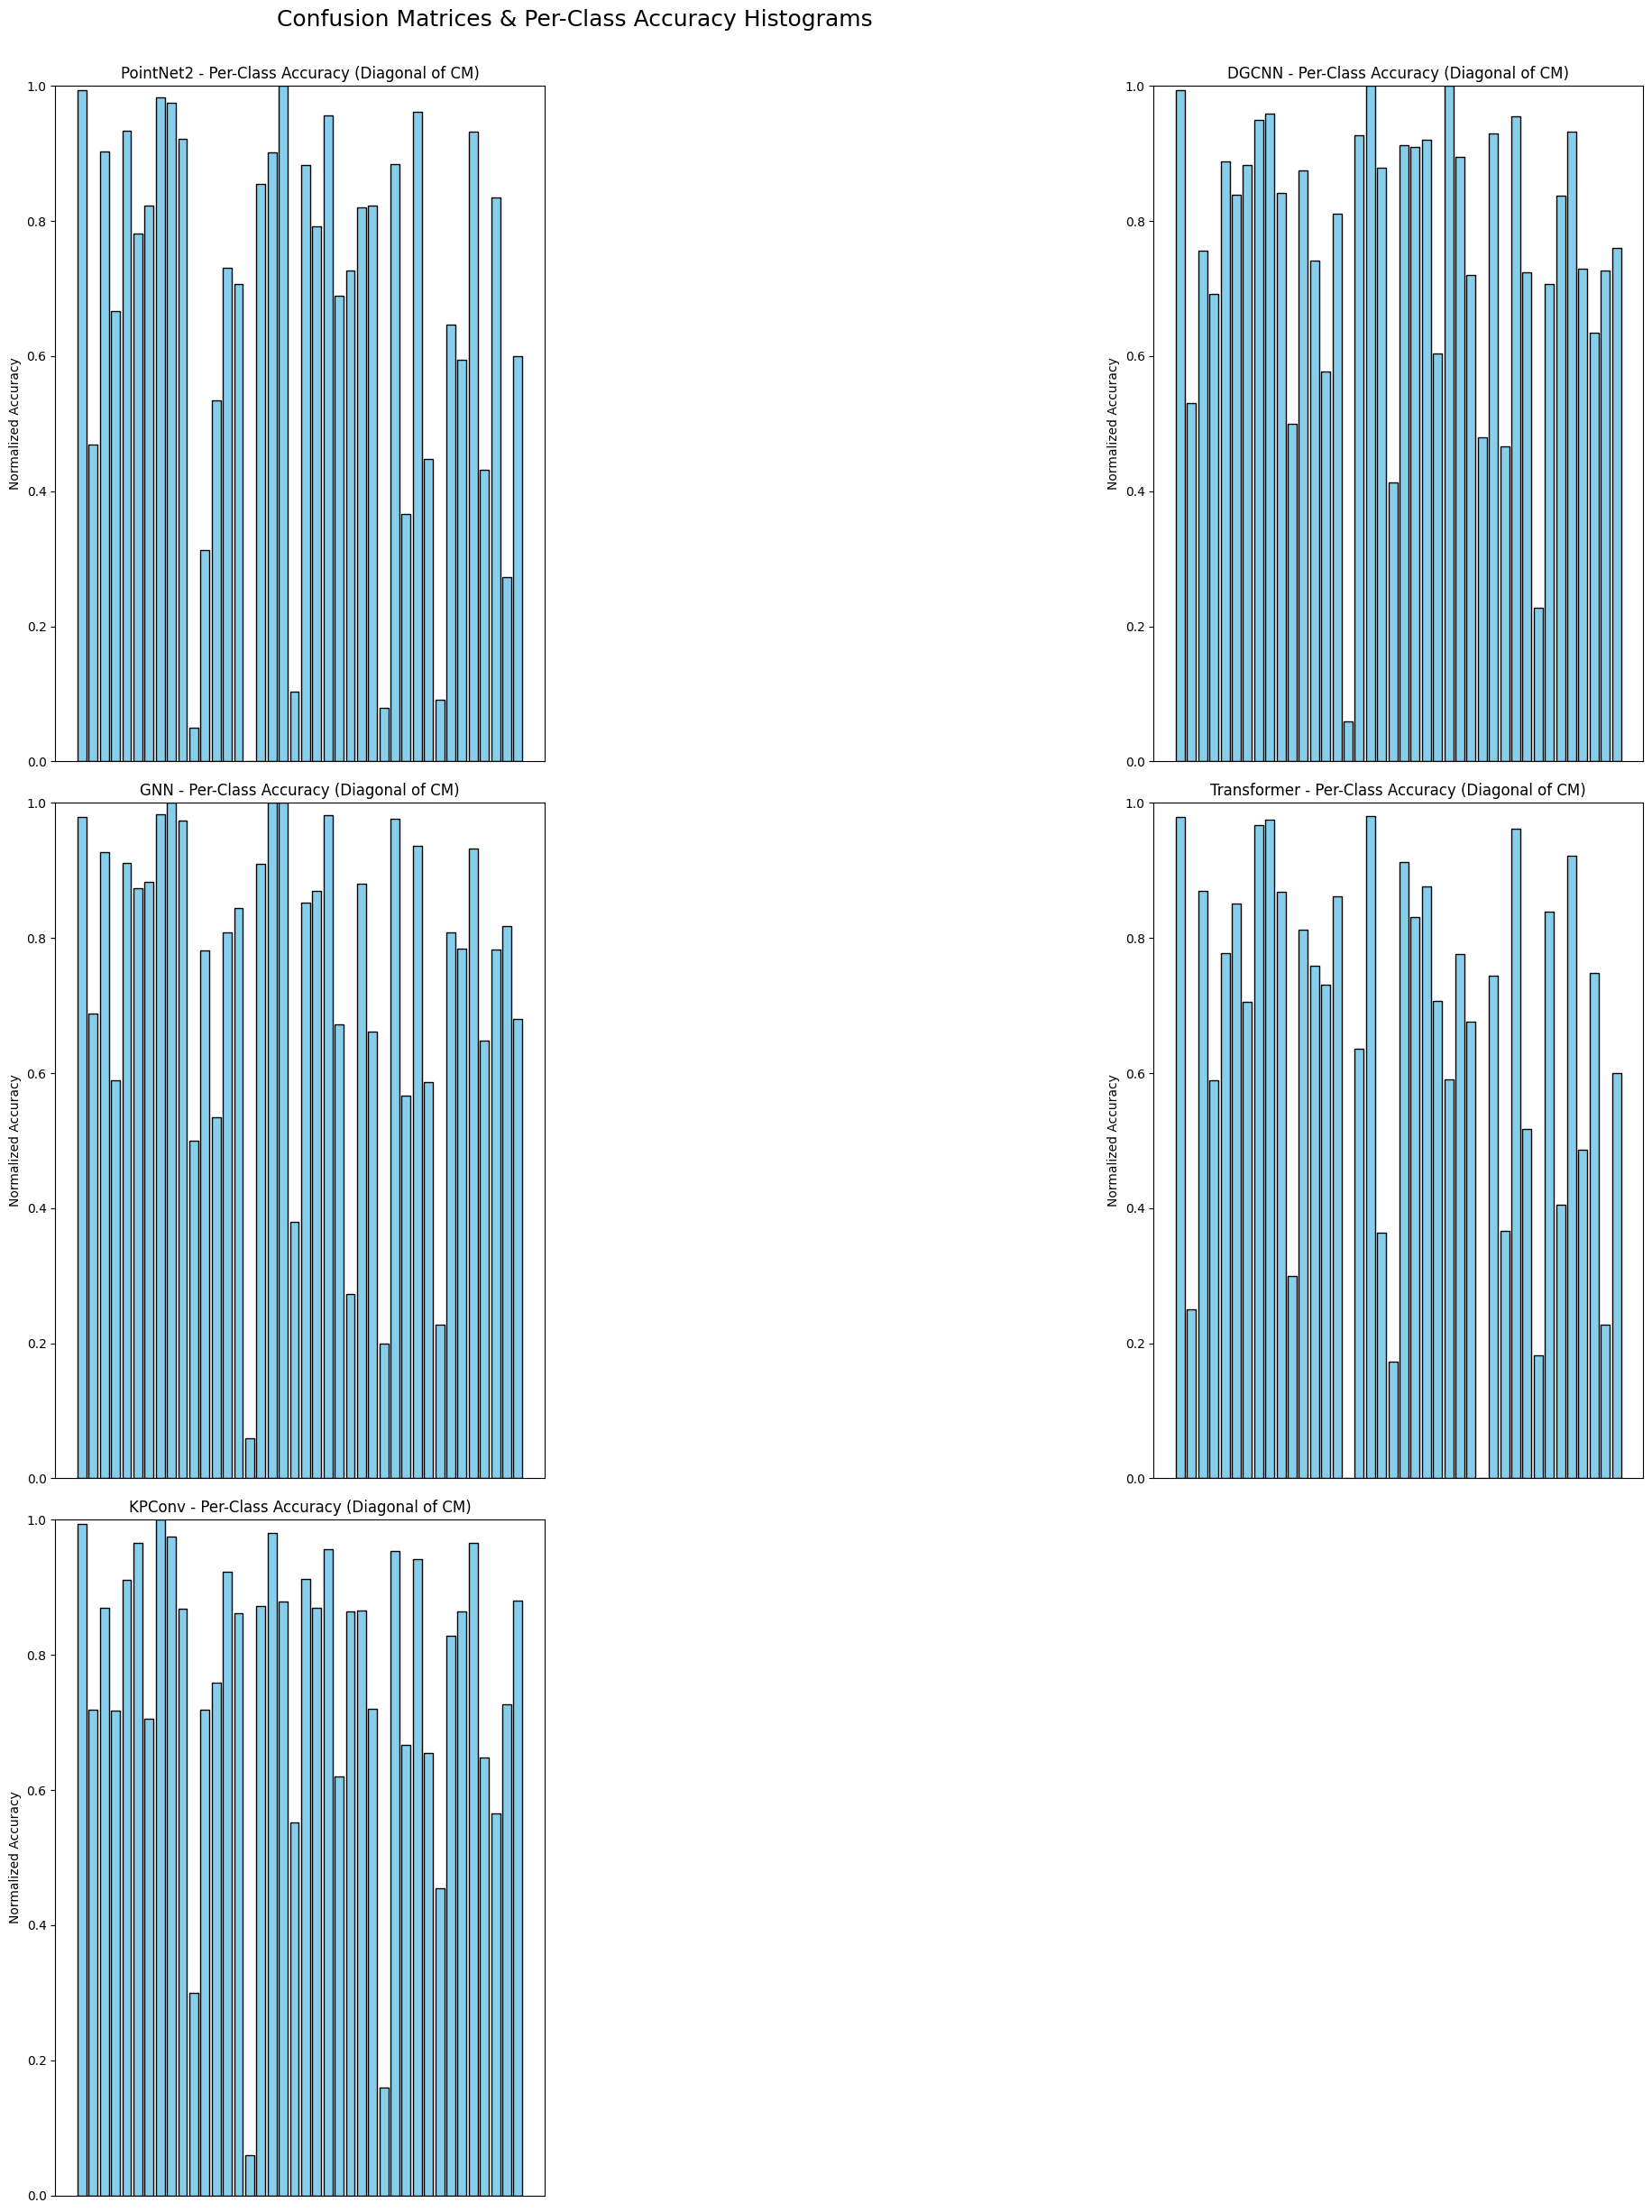

Saved: confusion_matrices_histograms.png


In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

cmaps = {
    'PointNet2':'Blues',
    'DGCNN':'Oranges',
    'GNN':'Greens',
    'Transformer':'Purples',
    'KPConv':'Reds'
}

trained_models = list(results.keys())
n = len(trained_models)
cols = 2
rows = (n+cols-1)//cols

plt.figure(figsize=(12*cols, 8*rows))

for idx, name in enumerate(trained_models):
    cm = results[name]['cm']
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    # Histogram per class (row sum = 1)
    plt.subplot(rows, cols*2, 2*idx+2)
    row_sums = cm_norm.sum(axis=1)
    # for each class, plot predicted counts as histogram
    plt.bar(range(len(class_names)), cm_norm.diagonal(), color='skyblue', edgecolor='black')
    plt.title(f"{name} - Per-Class Accuracy (Diagonal of CM)")
    if len(class_names) <= 30:
        plt.xticks(range(len(class_names)), class_names, rotation=90)
    else:
        plt.xticks([])
    plt.ylabel("Normalized Accuracy")
    plt.ylim(0,1)

plt.tight_layout()
plt.suptitle("Confusion Matrices & Per-Class Accuracy Histograms", y=1.02, fontsize=18)
plt.savefig("confusion_matrices_histograms.png", bbox_inches='tight')
plt.show()
print("Saved: confusion_matrices_histograms.png")

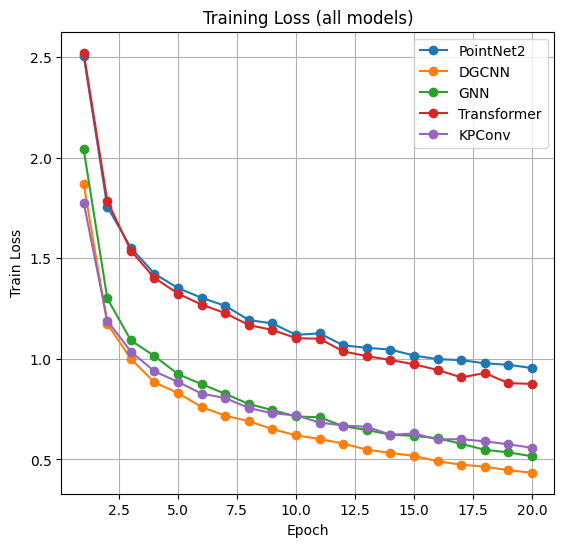

In [ ]:
# ---------------------------
# Plot training loss & accuracy curves (overlayed across models)
# ---------------------------

plt.figure(figsize=(14,6))
# Loss
plt.subplot(1,2,1)
for name in trained_models:
    plt.plot(range(1, len(results[name]['train_losses'])+1), results[name]['train_losses'], marker='o', label=name)
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Training Loss (all models)"); plt.legend()
plt.grid(True)

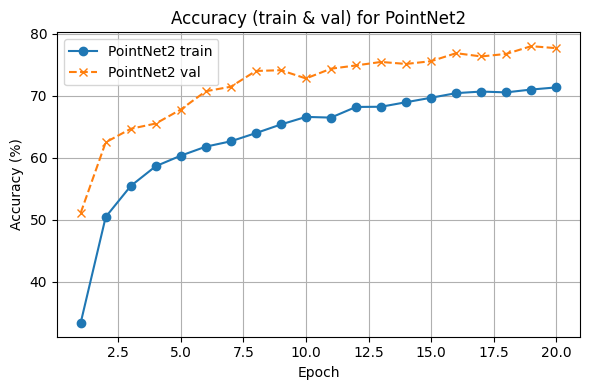

Saved: training_curves_PointNet2.png


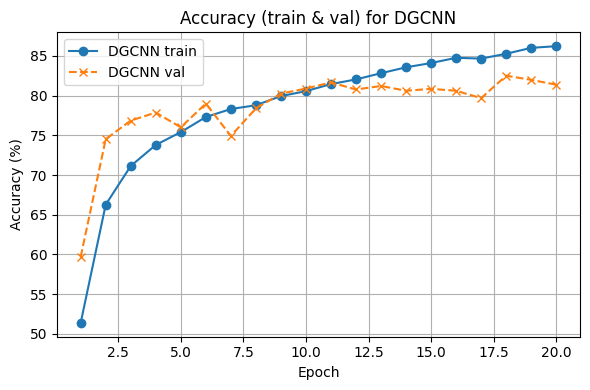

Saved: training_curves_DGCNN.png


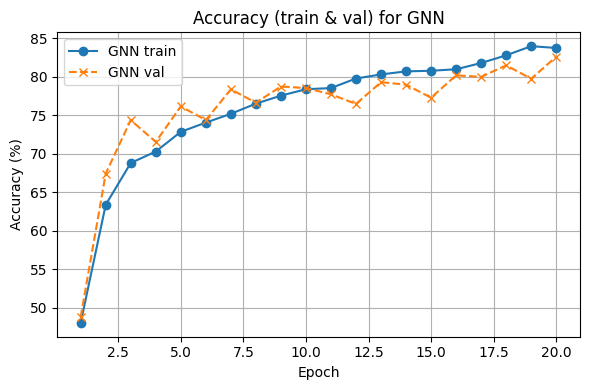

Saved: training_curves_GNN.png


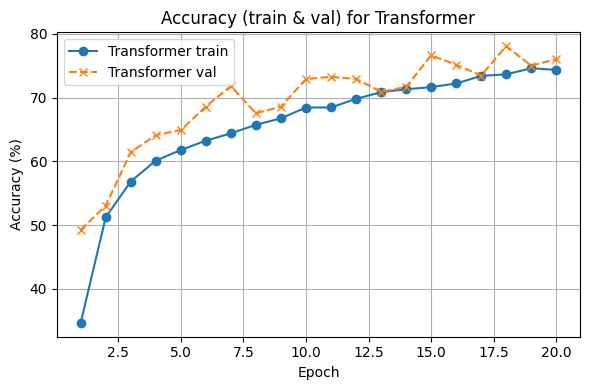

Saved: training_curves_Transformer.png


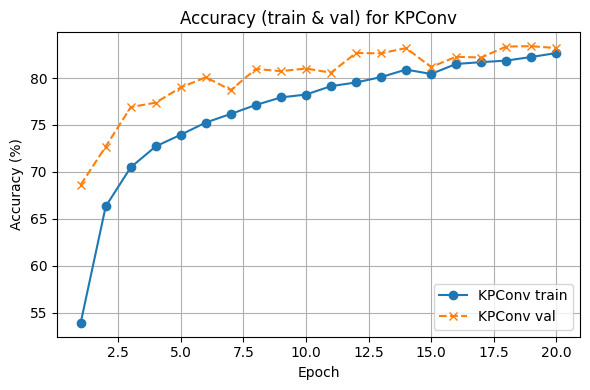

Saved: training_curves_KPConv.png


In [ ]:
for name in trained_models:
    plt.figure(figsize=(6,4))  # new figure for each model

    # plot training accuracy
    plt.plot(
        range(1, len(results[name]['train_accs'])+1),
        results[name]['train_accs'],
        marker='o',
        label=f"{name} train"
    )

    # plot validation accuracy if available
    if 'val_accs' in results[name]:
        plt.plot(
            range(1, len(results[name]['val_accs'])+1),
            results[name]['val_accs'],
            marker='x',
            linestyle='--',
            label=f"{name} val"
        )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy (train & val) for {name}")
    plt.legend()
    plt.grid(True)

    # save and show separately
    plt.tight_layout()
    plt.savefig(f"training_curves_{name}.png")
    plt.show()
    print(f"Saved: training_curves_{name}.png")